# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from celluloid import Camera
from IPython.display import HTML
sns.set_style('darkgrid')

# Functions

## Generate Data

In [2]:
def generateData(N, cov=np.array([[2,1],[1,2]]), alpha=5):
    
    x1 = np.random.multivariate_normal([-alpha, alpha], cov, N); y1 = np.repeat(1, N)
    x2 = np.random.multivariate_normal([alpha, -alpha], cov, N); y2 = np.repeat(0, N)
    
    X = np.concatenate((x1, x2))
    y = np.concatenate((y1, y2))
    
    p = np.random.permutation(2*N)
    
    X, y = X[p,:], y[p]
    
    return X, y

def createProcess(N, a, n_cycles = 5, alpha=0.1, constant = True):
    
    ex = np.random.randn(N)
    
    if constant:
        A = np.repeat(a, N).reshape(-1,N).T
        
    else:
        A = np.zeros((N, 2))
        a0 = a[0]
        a1 = a[1]

        for i in range(N):
            A[i, 0] = a0 + alpha * np.cos(2*np.pi*n_cycles*i/N)
            A[i, 1] = a1 + alpha * np.sin(np.pi*n_cycles*i/N)
            
    S = ex.copy()
    
    for n in range(2, N):
        
        a_iter = A[n, :]
        
        x = np.array([S[n-1], S[n-2]])
        S[n] = np.dot(x, a_iter) + ex[n]
        
    return ex, S, A

## Parameters to line equation

In [3]:
def params_to_line(x, a, b):
    return -(a/b)*x

## Sigmoid

In [4]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_diff(x):
    return sigmoid(x)*(1 - sigmoid(x))

## Kalman Filter (AR process)

In [5]:
def kalmanFilter(y,ex, beta=0.0001, alpha=0.001, gamma = 0.2, n_samples_estimate=10, initial_theta = None):
    
    N = len(ex)
    
    # Initialsation
    x = np.zeros((2, 1))
    
    if initial_theta is None:
        theta_n1_n1 = np.random.randn(2,1)
    else:
        theta_n1_n1 = initial_theta.reshape((2,1))
    
    
    # Hyper parameters, tuned and observe effects
    P_n1_n1 = alpha*np.eye(2)
    R = gamma*np.std(ex[0:n_samples_estimate])
    Q = beta*np.eye(2)
        
    
    theta_conv = np.zeros([2,N])
    
    ePlot = list()
    
    for n in range(2,N):
        
        x[0] = y[n-1]
        x[1] = y[n-2]
        
        theta_n_n1 = theta_n1_n1.copy()
        P_n_n1 = P_n1_n1 + Q
        
        yh = theta_n_n1.T @ x
        en = y[n] - yh
        
        ePlot.append(en)
        
        
        den = x.T @ P_n_n1 @ x + R
        
        kn = P_n_n1 @ x / den
        # Posterior update
        #
        theta_n_n = theta_n_n1 + kn * en
        P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1
        # Save
        theta_conv[0,n] = theta_n_n[0]
        theta_conv[1,n] = theta_n_n[1]
        
        # Remember for next step
        #
        theta_n1_n1 = theta_n_n.copy()
        P_n1_n1 = P_n_n.copy()
        
    
    print(P_n_n)
        
    return theta_n_n, theta_conv

## Extended Kalman Filter (EKF)

In [6]:
def EKF(X, y, beta=0.1, alpha=0.001, gamma = 0.2, initial_theta = None):
    
    N = len(X)
    
    
    # Initialsation
#     x = np.zeros((2, 1))
    
    if initial_theta is None:
        theta_n1_n1 = np.random.randn(2,1)
    else:
        theta_n1_n1 = initial_theta.reshape((2,1))
    
    
    # Hyper parameters, tuned and observe effects
    P_n1_n1 = alpha*np.eye(2)
#     R = gamma*np.std(ex[0:n_samples_estimate])
    R = 0.1
    Q = beta*np.eye(2)
        
    
    theta_conv = np.zeros([2,N])
    
    ePlot = list()
    
    for n in range(N):
        
#         x[0] = y[n-1]
#         x[1] = y[n-2]
        xn = X[n,:].reshape((2,1))
        
        theta_n_n1 = theta_n1_n1.copy()
        P_n_n1 = P_n1_n1 + Q
        
        in_val = (theta_n_n1.T @ xn)[0,0]
        
#         yh = sigmoid(theta_n_n1.T @ xn)
        yh = sigmoid(in_val)
        en = y[n] - yh
#         print(en)
        
        temp = np.exp(-in_val) * yh**2
        
        H = np.array([[xn[0,0]*temp, xn[1,0]*temp]])
        
        ePlot.append(en)
        
        
        den = H @ P_n_n1 @ H.T + R
        
        kn = P_n_n1 @ H.T / den
        
        # Posterior update
        #
        theta_n_n = theta_n_n1 + kn * en
        P_n_n = (np.eye(2) - kn @ H) @ P_n_n1
        # Save
        theta_conv[0,n] = theta_n_n[0]
        theta_conv[1,n] = theta_n_n[1]
        
        # Remember for next step
        #
        theta_n1_n1 = theta_n_n.copy()
        P_n1_n1 = P_n_n.copy()

        
    
        
    return theta_n_n, theta_conv

##  Sequential Importance Sampling (SIS)

In [7]:
def particle_liklihood(y0, yh, sig):
    return stats.norm.pdf(y0, loc = yh, scale = sig)


def SIS_AR(T, L, beta, theta_true, resample=False, resample_prop = 1, constant = False, n_cycles = 3):
    ESS = list()
    resample_thresh = int(L*resample_prop)
    ex, S, A = createProcess(T, theta_true, constant = constant, n_cycles = n_cycles)
    
    
    std = np.std(ex[:10]) # process noise variance
#     std = 1
    
    particles = np.random.randn(2, L) # randomly initiate the particles
    pweights = np.repeat(1/L, L)
    
    weight_hist = list()
    weight_hist.append(pweights)
    
    param_est_list = list()
    
    for t in range(2,T):
        x = np.array([S[t-1], S[t-2]])

        particles += beta*np.random.randn(2, L)

        sh = x @ particles
        lhoods = particle_liklihood(S[t], sh, std)


        pweights = pweights.copy()
        pweights *= lhoods

        pweights /= pweights.sum()


        param0 = pweights @ particles[0]
        param1 = pweights @ particles[1]
        weight_hist.append(pweights)
        param_est_list.append((param0, param1))

        ess = 1/sum(pweights**2)
        ESS.append(ess)
        
        if resample and ess < resample_thresh:
            new_parts = np.zeros((2, L))
            cdf = np.cumsum(pweights)
            u = np.random.random(1)/L
            thresh = np.concatenate((u, u + np.cumsum(np.repeat(1/L, L-1))))
            
            for l in range(L):
                i = np.where(thresh[l] < cdf)[0][0]

                new_parts[:,l] = particles[:,i]
                
            pweights = np.repeat(1/L, L)
            particles = new_parts

        
    
    return param_est_list, weight_hist, ESS, A, S, ex

## Particle Filter

In [8]:
def particleFilter_LR(X, y, L, beta, resample=True, resample_prop = 1):
    std = 0.5
    T = len(y)
    ESS = list()

    particles = beta*np.random.randn(2, L) # randomly initiate the particles
    pweights = np.repeat(1/L, L)

    weight_hist = list()
    weight_hist.append(pweights)
    resample_thresh = int(L*resample_prop)

    param_est_list = list()
    
    for t in range(T):
        xt = X[t,:]
        yt = y[t]

        particles += beta*np.random.randn(2, L)

        sh = sigmoid(xt @ particles)
        lhoods = particle_liklihood(yt, sh, std)

        pweights = pweights.copy()
        pweights *= lhoods

        pweights /= pweights.sum()


        param0 = pweights @ particles[0]
        param1 = pweights @ particles[1]

        weight_hist.append(pweights)
        param_est_list.append((param0, param1))
        
        ess = 1/sum(pweights**2)
        ESS.append(ess)

        if resample and ess < resample_thresh:
            new_parts = np.zeros((2, L))
            cdf = np.cumsum(pweights)
            u = np.random.random(1)/L
            thresh = np.concatenate((u, u + np.cumsum(np.repeat(1/L, L-1))))

            for l in range(L):
                
                i = np.where(thresh[l] < cdf)[0][0]

                new_parts[:,l] = particles[:,i]


            pweights = np.repeat(1/L, L)
            particles = new_parts
        
    return param_est_list, weight_hist, ESS  

# Application (results)

## SIS Auto Regressive

Text(0.5, 1.0, 'Particle Weights over time')

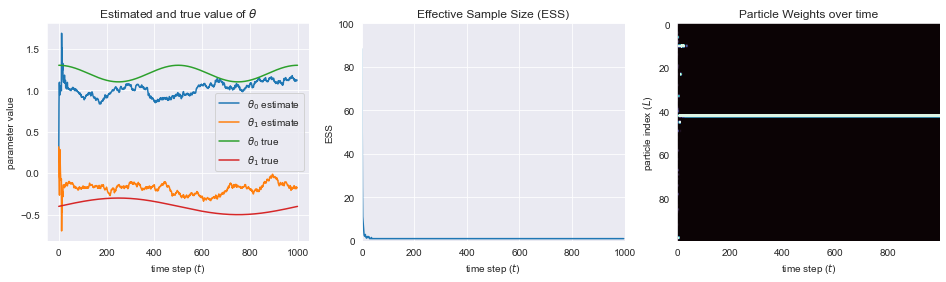

In [10]:
fig_SIS, ax_SIS = plt.subplots(ncols = 3, figsize = (16,4))

np.random.seed(42)

L = 100
T = 1000
a1 = np.array([1.2,-0.4])

param_est_list, weight_hist, ESS, A, S, ex = SIS_AR(T, L, 0.01, a1, constant = False, resample = False, n_cycles=2)
param0_est, param1_est = zip(*param_est_list)

ax_SIS[0].plot(range(len(param0_est)), param0_est, label = f'$\\theta_0$ estimate')
ax_SIS[0].plot(range(len(param1_est)), param1_est, label = f'$\\theta_1$ estimate')
ax_SIS[0].plot(range(len(A)), A[:,0], label = f'$\\theta_0$ true')
ax_SIS[0].plot(range(len(A)), A[:,1], label = f'$\\theta_1$ true')
ax_SIS[0].set_xlabel(f'time step ($t$)')
ax_SIS[0].set_ylabel(f'parameter value')
ax_SIS[0].legend()
ax_SIS[0].set_title(f'Estimated and true value of $\\theta$')

ax_SIS[1].plot(range(len(ESS)), ESS)
ax_SIS[1].set_ylim((0,L))
ax_SIS[1].set_xlim((0,T))
ax_SIS[1].set_xlabel(f'time step ($t$)')
ax_SIS[1].set_ylabel(f'ESS')
ax_SIS[1].set_title(f'Effective Sample Size (ESS)')


# ax_SIS[2].bar(range(L), weight_hist[-1])
ax_SIS[2].imshow(np.array(weight_hist).T, aspect = 'auto', vmax = 0.1, cmap = 'mako')
ax_SIS[2].grid()
ax_SIS[2].set_ylabel(f'particle index ($L$)')
ax_SIS[2].set_xlabel(f'time step ($t$)')
ax_SIS[2].set_title(f'Particle Weights over time')

# fig_SIS.savefig('SIS_AutoReg.pdf')

Text(0.5, 1.0, 'Particle Weights over time')

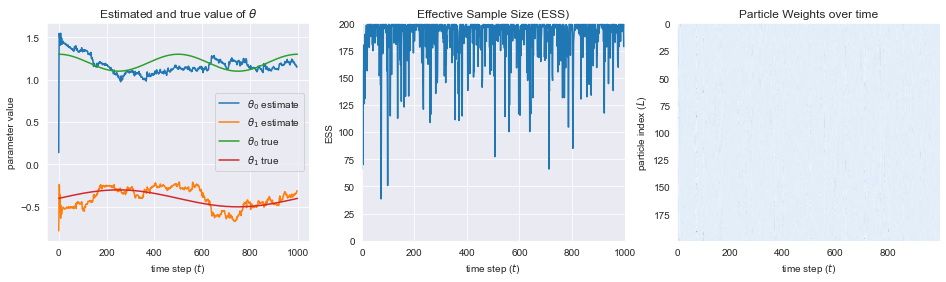

In [10]:
fig_SIS_re, ax_SIS_re = plt.subplots(ncols = 3, figsize = (16,4))

# np.random.seed(42)

L = 200
T = 1000
a1 = np.array([1.2,-0.4])

param_est_list, weight_hist, ESS, A, S, ex = SIS_AR(T, L, 0.01, a1, constant = False, resample = True, n_cycles=2, resample_prop=1)
param0_est, param1_est = zip(*param_est_list)

ax_SIS_re[0].plot(range(len(param0_est)), param0_est, label = f'$\\theta_0$ estimate')
ax_SIS_re[0].plot(range(len(param1_est)), param1_est, label = f'$\\theta_1$ estimate')
ax_SIS_re[0].plot(range(len(A)), A[:,0], label = f'$\\theta_0$ true')
ax_SIS_re[0].plot(range(len(A)), A[:,1], label = f'$\\theta_1$ true')
ax_SIS_re[0].set_xlabel(f'time step ($t$)')
ax_SIS_re[0].set_ylabel(f'parameter value')
ax_SIS_re[0].legend()
ax_SIS_re[0].set_title(f'Estimated and true value of $\\theta$')

ax_SIS_re[1].plot(range(len(ESS)), ESS)
ax_SIS_re[1].set_ylim((0,L))
ax_SIS_re[1].set_xlim((0,T))
ax_SIS_re[1].set_xlabel(f'time step ($t$)')
ax_SIS_re[1].set_ylabel(f'ESS')
ax_SIS_re[1].set_title(f'Effective Sample Size (ESS)')


# ax_SIS_re[2].bar(range(L), weight_hist[-1])
ax_SIS_re[2].imshow(np.array(weight_hist).T, aspect = 'auto', vmax = 0.05, cmap = 'Blues')
ax_SIS_re[2].grid()
ax_SIS_re[2].set_ylabel(f'particle index ($L$)')
ax_SIS_re[2].set_xlabel(f'time step ($t$)')
ax_SIS_re[2].set_title(f'Particle Weights over time')

# fig_SIS_re.savefig('SIS_resample_AutoReg.pdf')

## EKF

sklearn sol: [-2.64140449  2.56423343]
EKF sol:  [-2.20938999  1.43589927]


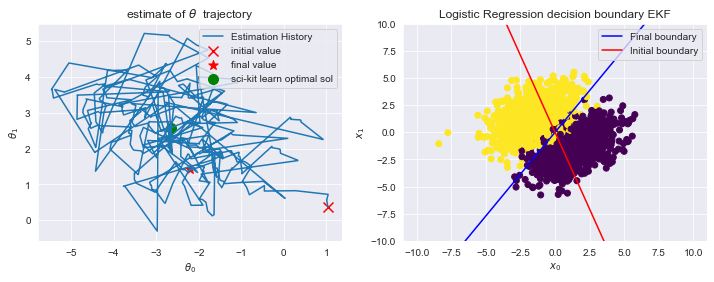

In [13]:
fig_ekf, ax_ekf = plt.subplots(ncols = 2, figsize = (12,4))
np.random.seed(100)
X, y = generateData(1000, alpha = 1.5)
true_sol = LogisticRegression().fit(X, y).coef_.squeeze()
print('sklearn sol:', true_sol)


theta_est, theta_plot = EKF(X, y)
print('EKF sol: ', theta_est.squeeze())

ax_ekf[0].plot(theta_plot[0], theta_plot[1], label = 'Estimation History')
ax_ekf[0].scatter(theta_plot[0,0], theta_plot[1,0], marker = 'x', c = 'r', s = 100, label = 'initial value')
ax_ekf[0].scatter(theta_plot[0,-1], theta_plot[1,-1], marker = '*', c = 'r', s = 100, label = 'final value')
ax_ekf[0].scatter(true_sol[0], true_sol[1], marker = 'o', c = 'g', s = 100, label = 'sci-kit learn optimal sol')
# ax_ekf[0].grid()
ax_ekf[0].set_xlabel(f'$\\theta_0$')
ax_ekf[0].set_ylabel(f'$\\theta_1$')
ax_ekf[0].set_title(f'estimate of $\\theta$  trajectory')
ax_ekf[0].legend()

y_line_final = params_to_line(np.array([-10,10]), theta_est[0], theta_est[1])
y_line_initial = params_to_line(np.array([-10,10]), theta_plot[0,0], theta_plot[1,0])

ax_ekf[1].scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax_ekf[1].plot([-10,10], y_line_final, c = 'b', label = 'Final boundary')
ax_ekf[1].plot([-10,10], y_line_initial, c = 'r', label = 'Initial boundary')
# ax_ekf[1].grid()
ax_ekf[1].set_xlabel(f'$x_0$')
ax_ekf[1].set_ylabel(f'$x_1$')
ax_ekf[1].set_title(f'Logistic Regression decision boundary EKF')
ax_ekf[1].legend()
ax_ekf[1].set_ylim((-10,10))

fig_ekf.savefig('EKF.pdf')

sklearn sol: [-1.79214017  1.67391578]
EKF sol:  [-3.63001196  2.22013361]


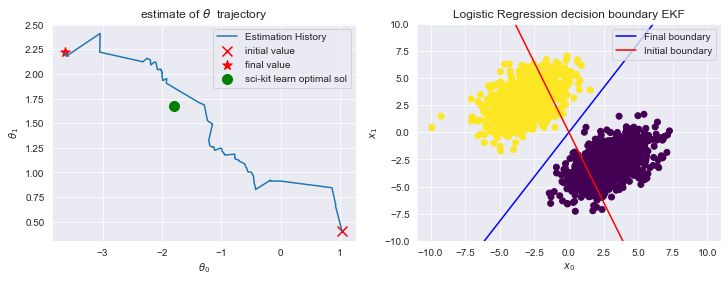

In [14]:
fig_ekf, ax_ekf = plt.subplots(ncols = 2, figsize = (12,4))
np.random.seed(100)
X, y = generateData(1000, alpha = 3)
true_sol = LogisticRegression().fit(X, y).coef_.squeeze()
print('sklearn sol:', true_sol)


theta_est, theta_plot = EKF(X, y)
print('EKF sol: ', theta_est.squeeze())

ax_ekf[0].plot(theta_plot[0], theta_plot[1], label = 'Estimation History')
ax_ekf[0].scatter(theta_plot[0,0], theta_plot[1,0], marker = 'x', c = 'r', s = 100, label = 'initial value')
ax_ekf[0].scatter(theta_plot[0,-1], theta_plot[1,-1], marker = '*', c = 'r', s = 100, label = 'final value')
ax_ekf[0].scatter(true_sol[0], true_sol[1], marker = 'o', c = 'g', s = 100, label = 'sci-kit learn optimal sol')
# ax_ekf[0].grid()
ax_ekf[0].set_xlabel(f'$\\theta_0$')
ax_ekf[0].set_ylabel(f'$\\theta_1$')
ax_ekf[0].set_title(f'estimate of $\\theta$  trajectory')
ax_ekf[0].legend()

y_line_final = params_to_line(np.array([-10,10]), theta_est[0], theta_est[1])
y_line_initial = params_to_line(np.array([-10,10]), theta_plot[0,0], theta_plot[1,0])

ax_ekf[1].scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax_ekf[1].plot([-10,10], y_line_final, c = 'b', label = 'Final boundary')
ax_ekf[1].plot([-10,10], y_line_initial, c = 'r', label = 'Initial boundary')
# ax_ekf[1].grid()
ax_ekf[1].set_xlabel(f'$x_0$')
ax_ekf[1].set_ylabel(f'$x_1$')
ax_ekf[1].set_title(f'Logistic Regression decision boundary EKF')
ax_ekf[1].legend()
ax_ekf[1].set_ylim((-10,10))

fig_ekf.savefig('EKF_sep.pdf')

## Particle Filter

sklearn sol: [-2.64140449  2.56423343]
PF solution: [-1.72227823  1.63299717]


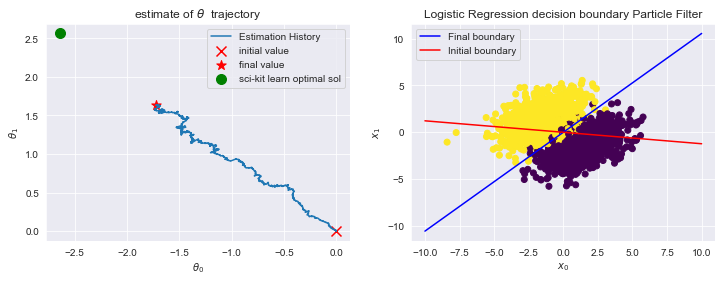

In [9]:
fig_pf, ax_pf = plt.subplots(ncols = 2, figsize = (12,4))
np.random.seed(100)
X, y = generateData(1000, alpha = 1.5)
L = 200
beta = 0.01

true_sol = LogisticRegression().fit(X, y).coef_.squeeze()
print('sklearn sol:', true_sol)




theta_est_lst, weight_hist, ESS = particleFilter_LR(X, y, L, beta, resample_prop = 1)
theta0, theta1 = zip(*theta_est_lst)
print('PF solution:', np.array([theta0[-1], theta1[-1]]))

ax_pf[0].plot(theta0, theta1, label = 'Estimation History')
ax_pf[0].scatter(theta0[0], theta1[0], marker = 'x', c = 'r', s = 100, label = 'initial value')
ax_pf[0].scatter(theta0[-1], theta1[-1], marker = '*', c = 'r', s = 100, label = 'final value')
ax_pf[0].scatter(true_sol[0], true_sol[1], marker = 'o', c = 'g', s = 100, label = 'sci-kit learn optimal sol')
# ax_pf[0].grid()
ax_pf[0].set_xlabel(f'$\\theta_0$')
ax_pf[0].set_ylabel(f'$\\theta_1$')
ax_pf[0].set_title(f'estimate of $\\theta$  trajectory')
ax_pf[0].legend()

y_line_final = params_to_line(np.array([-10,10]), theta0[-1], theta1[-1])
y_line_initial = params_to_line(np.array([-10,10]), theta0[0], theta1[0])

ax_pf[1].scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax_pf[1].plot([-10,10], y_line_final, c = 'b', label = 'Final boundary')
ax_pf[1].plot([-10,10], y_line_initial, c = 'r', label = 'Initial boundary')
# ax_pf[1].grid()
ax_pf[1].set_xlabel(f'$x_0$')
ax_pf[1].set_ylabel(f'$x_1$')
ax_pf[1].set_title(f'Logistic Regression decision boundary Particle Filter')
ax_pf[1].legend()

# fig_pf.savefig('PF_LR.pdf')

sklearn sol: [-1.79214017  1.67391578]
PF solution: [-1.06431316  1.02319093]


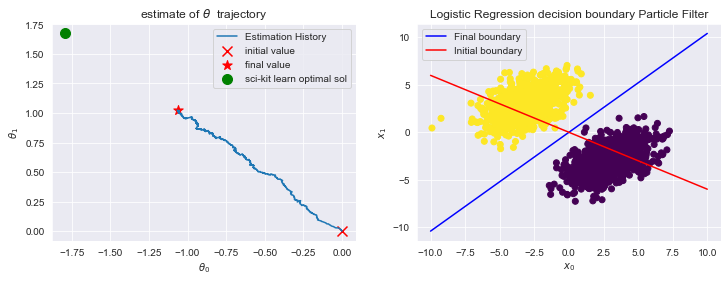

In [54]:
fig_pf, ax_pf = plt.subplots(ncols = 2, figsize = (12,4))
np.random.seed(100)
X, y = generateData(1000, alpha = 3)
L = 200
beta = 0.01

true_sol = LogisticRegression().fit(X, y).coef_.squeeze()
print('sklearn sol:', true_sol)




theta_est_lst, weight_hist, ESS = particleFilter_LR(X, y, L, beta, resample_prop = 0.9)
theta0, theta1 = zip(*theta_est_lst)
print('PF solution:', np.array([theta0[-1], theta1[-1]]))

ax_pf[0].plot(theta0, theta1, label = 'Estimation History')
ax_pf[0].scatter(theta0[0], theta1[0], marker = 'x', c = 'r', s = 100, label = 'initial value')
ax_pf[0].scatter(theta0[-1], theta1[-1], marker = '*', c = 'r', s = 100, label = 'final value')
ax_pf[0].scatter(true_sol[0], true_sol[1], marker = 'o', c = 'g', s = 100, label = 'sci-kit learn optimal sol')
# ax_pf[0].grid()
ax_pf[0].set_xlabel(f'$\\theta_0$')
ax_pf[0].set_ylabel(f'$\\theta_1$')
ax_pf[0].set_title(f'estimate of $\\theta$  trajectory')
ax_pf[0].legend()

y_line_final = params_to_line(np.array([-10,10]), theta0[-1], theta1[-1])
y_line_initial = params_to_line(np.array([-10,10]), theta0[0], theta1[0])

ax_pf[1].scatter(X[:,0], X[:,1], c = y, cmap = 'viridis')
ax_pf[1].plot([-10,10], y_line_final, c = 'b', label = 'Final boundary')
ax_pf[1].plot([-10,10], y_line_initial, c = 'r', label = 'Initial boundary')
# ax_pf[1].grid()
ax_pf[1].set_xlabel(f'$x_0$')
ax_pf[1].set_ylabel(f'$x_1$')
ax_pf[1].set_title(f'Logistic Regression decision boundary Particle Filter')
ax_pf[1].legend()

# fig_pf.savefig('PF_LR_sep.pdf')